In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import seaborn as sns
from IPython.display import display, Math
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

import sys
import os
sys.path.append(os.path.abspath('../../utils'))
from Perturbe_Algs import Attacks


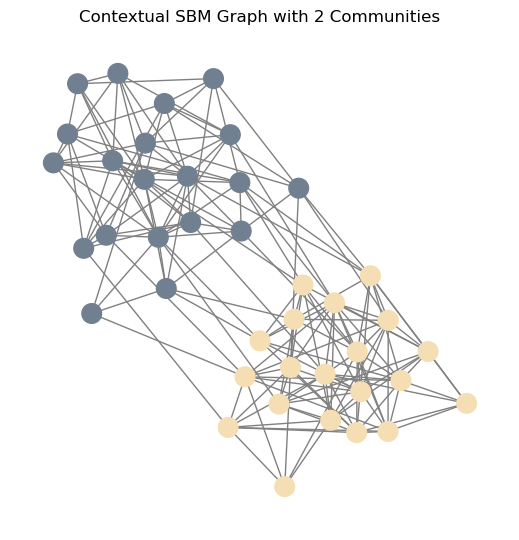

In [2]:
# Create a contextual stochastic block model (SBM) graph with two communities
n = [20,20] # Number of nodes in each community
N = np.sum(n)       
p_in = 0.4  
p_out = 0.05
p_matrix = np.full((2,2),p_out)
np.fill_diagonal(p_matrix,p_in)
# Greate SBM graph
G = nx.stochastic_block_model(n, p_matrix, seed=1)
for u in range(N):
        if u< n[1]:
            G.nodes[u]['label'] = 1
        else:
            G.nodes[u]['label'] = -1
# Create node feature x_i = \pm c + N(0,1)
d = 100
for u in G.nodes():
    G.nodes[u]['feature'] =  2*G.nodes[u]['label'] + np.random.normal(0, 1,d)


# Visualize result
colors = ['#F5DEB3', '#708090']
cmap = mcolors.ListedColormap(colors)
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G, seed=1)  # Layout for visualization
node_colors = [G.nodes[node]['label'] for node in G.nodes()]  # Color by label
nx.draw(G, pos, node_color=node_colors, cmap=cmap, node_size=200, edge_color='gray', with_labels=False, alpha =1)
plt.title("Contextual SBM Graph with 2 Communities")
plt.show()

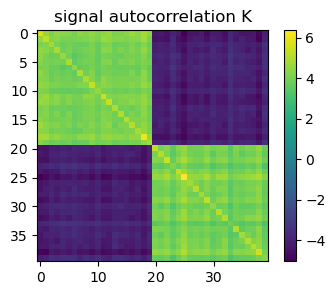

In [3]:
# (1) Compute the signal autocorrelation matrix K
# K = 1/N \sum_{i=1}^N x_i x_i^T
X = np.zeros((N,d))
for u in range(N):
        X[u,:] =  G.nodes[u]['feature']

K_cSBM = X@X.T/d

plt.figure(figsize = (4,3))
plt.imshow(K_cSBM,interpolation='None')
plt.colorbar()
plt.title('signal autocorrelation K')
plt.show()


In [5]:
# Set up parameters for the attack
m = 20
J = np.ones((N,N))
I = np.eye(N)
A_SBM = nx.adjacency_matrix(G).todense()

A = torch.tensor(A_SBM).type(torch.double)
n = A.shape[0]
K = torch.tensor(K_cSBM).type(torch.double)
X = torch.tensor(X).type(torch.double)
Knp = K.cpu().numpy()


print(f'Perturbe {m: d} edges')
alpha = 1
max_iter = 100
mute = True


Perturbe  20 edges


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Attack_SBM = Attacks(A, K, m, alpha, max_iter, filter = 'lap').to(device)
A_pgd_wst = Attack_SBM.pgd_wst()
A_random = Attack_SBM.randomAttack()
A_pgd_avg = Attack_SBM.pgd_avg()




Using device: cpu


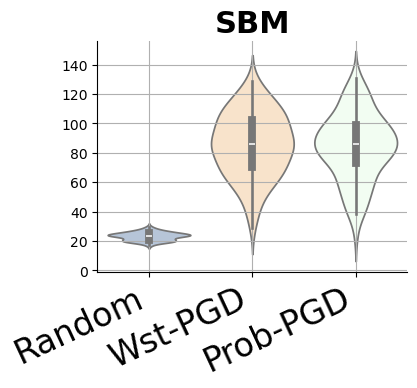

In [8]:
#  Compute emeprical embedding perturbations for each graph signal
L = torch.diag(torch.sum(A, axis = 1)) - A
L_random = torch.diag(torch.sum(A_random, axis = 1)) - A_random
L_pgd_avg = torch.diag(torch.sum(A_pgd_avg, axis = 1)) - A_pgd_avg
L_pgd_wst = torch.diag(torch.sum(A_pgd_wst, axis = 1)) - A_pgd_wst
delta_x_random = np.zeros(d)
delta_x_pgd_avg = np.zeros(d)
delta_x_pgd_wst = np.zeros(d)
delta_x_greedy_avg_CPU = np.zeros(d)
for j in range(d):
  delta_x_random[j] = torch.norm(((L-L_random) ) @ X[:,j], p ='fro').item()
  delta_x_pgd_avg[j] = torch.norm(((L-L_pgd_avg) ) @ X[:,j], p ='fro').item()
  delta_x_pgd_wst[j] = torch.norm(((L-L_pgd_wst) ) @ X[:,j], p ='fro').item()


data = [delta_x_random, delta_x_pgd_wst, delta_x_pgd_avg]
labels = ['Random', 'Wst-PGD', 'Prob-PGD']
colors = ['lightsteelblue', 'bisque', 'honeydew']

plt.figure(figsize=(4, 3))
sns.violinplot(data=data, palette=colors)
plt.xticks(range(len(labels)), labels, fontsize = 24,rotation=25, ha='right')
plt.title("SBM",fontsize = 22,fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True)
plt.show()


In [11]:
# Validation of the theory
theory_val = (Attack_SBM.obj_avg(abs(A-A_random)).item())
print(f'Random attack: embedding perturbation (theory): {theory_val:.2f}, embedding perturbation (sample):{np.mean(delta_x_random**2):.2f} ')
theory_val = (Attack_SBM.obj_avg(abs(A-A_pgd_avg)).item())
print(f'Prob-PGD attack: embedding perturbation (theory): {theory_val:.2f}, embedding perturbation (sample):{np.mean(delta_x_pgd_avg**2):.2f} ')
theory_val = (Attack_SBM.obj_avg(abs(A-A_pgd_wst)).item())
print(f'Wst-PGD attack: embedding perturbation (theory): {theory_val:.2f}, embedding perturbation (sample):{np.mean(delta_x_pgd_wst**2):.2f} ')


Random attack: embedding perturbation (theory): 545.93, embedding perturbation (sample):545.93 
Prob-PGD attack: embedding perturbation (theory): 7599.55, embedding perturbation (sample):7599.55 
Wst-PGD attack: embedding perturbation (theory): 7778.33, embedding perturbation (sample):7778.33 
